## 1. Project Goals

**Objective**: Predict ingredient prices (Milk, Sugar, Bananas, Starter Culture) 2-4 weeks in advance using machine learning

---

## Data Flow Summary

**Raw Data** (`data/raw/`):
- `wfp_food_prices_nga.csv` - Raw WFP food price data
- `culture_2022.csv` through `culture_2025.csv` - Raw UN Comtrade import data
- `external_signals.csv` - Fuel prices and inflation (created by `create_external_signals.py`)

**Processed Data** (`data/processed/`):
- `wfp_monthly_normalized.csv` - WFP data normalized to 1kg, monthly averages
- `culture_monthly_prices.csv` - Culture data filtered and aggregated monthly
- `culture_detailed_records.csv` - All valid culture import records

**Final Output** (`data/`):
- `integrated_food_prices.csv` - Complete dataset with all prices and external signals (ready for modeling)


## 2. Data Collection

### 2.1 Core Food Price Data

#### WFP (World Food Programme) Data
- **Source**: World Food Programme food price database
- **Commodities**: Milk (powder), Bananas, Sugar
- **Format**: Retail prices in NGN and USD
- **File**: `data/raw/wfp_food_prices_nga.csv`
- **Coverage**: 2022-2025

#### UN Comtrade Data
- **Source**: UN Comtrade international trade database
- **Commodity**: Starter culture (bacteria) imports to Nigeria
- **Format**: Import records with quantity and value
- **Files**: `data/raw/culture_2022.csv` through `culture_2025.csv`

### 2.2 External Signals

#### Fuel Prices (NBS)
- **Source**: National Bureau of Statistics (NBS) e-Library
- **URL**: https://www.nigerianstat.gov.ng/elibrary
- **Collection Method**: AI-assisted web scraping
- **Data**: PMS (Petrol) and AGO (Diesel) prices in NGN per liter
- **Why**: Fuel costs directly impact transportation and production costs

#### Inflation Data (NBS)
- **Source**: National Bureau of Statistics (NBS) e-Library
- **Collection Method**: AI-assisted web scraping
- **Data**: Monthly CPI and inflation rates (YoY %)
- **Why**: General inflation trends provide macroeconomic context

#### Forex Rates (CBN)
- **Source**: Calculated from WFP data (milk NGN/USD ratio)
- **Why**: Import costs are USD-priced; exchange rate fluctuations affect local prices



In [32]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Data
print("Raw data:")
for f in sorted(RAW_DIR.glob("*.csv")):
    print(f"  - {f.name}")


Raw data:
  - culture_2022.csv
  - culture_2023.csv
  - culture_2024.csv
  - culture_2025.csv
  - external_signals.csv
  - wfp_food_prices_nga.csv


## 3. Data Transformation

### 3.1 WFP Data Processing

**Goal**: Normalize all prices to 1kg units for consistency

**Normalization Rules**:
- Milk (powder): 400g → multiply by 2.5
- Sugar: 500g → multiply by 2
- Bananas: 1.3kg → divide by 1.3


In [33]:
# Load and inspect WFP data
wfp_raw = pd.read_csv(RAW_DIR / "wfp_food_prices_nga.csv", skiprows=[1], low_memory=False)
wfp_raw['date'] = pd.to_datetime(wfp_raw['date'])

# Filter for target commodities and date range
target_commodities = ['Milk (powder)', 'Bananas', 'Sugar']
wfp_filtered = wfp_raw[
    (wfp_raw['date'] >= '2022-01-01') & 
    (wfp_raw['commodity'].isin(target_commodities))
].copy()

print(f"Total WFP records (2022+): {len(wfp_filtered)}")
print(f"\nCommodities:")
print(wfp_filtered['commodity'].value_counts())
print(f"\nUnits:")
print(wfp_filtered.groupby(['commodity', 'unit']).size())


Total WFP records (2022+): 1544

Commodities:
commodity
Milk (powder)    641
Sugar            452
Bananas          451
Name: count, dtype: int64

Units:
commodity      unit  
Bananas        1.3 KG    451
Milk (powder)  400 G     641
Sugar          500 G     452
dtype: int64


In [35]:
# Normalize prices to 1kg
def normalize_price(row):
    if row['commodity'] == 'Milk (powder)' and row['unit'] == '400 G':
        return row['price'] * 2.5, row['usdprice'] * 2.5
    elif row['commodity'] == 'Sugar' and row['unit'] == '500 G':
        return row['price'] * 2, row['usdprice'] * 2
    elif row['commodity'] == 'Bananas' and row['unit'] == '1.3 KG':
        return row['price'] / 1.3, row['usdprice'] / 1.3
    else:
        return row['price'], row['usdprice']

wfp_filtered[['price_norm', 'usdprice_norm']] = wfp_filtered.apply(
    normalize_price, axis=1, result_type='expand'
)

# Filter outliers using reasonable price ranges (based on actual market prices)
print("Outlier filter:")
REASONABLE_RANGES = {
    'Bananas': (100, 800),      # 100-800 NGN/kg
    'Milk (powder)': (3000, 15000),  # 3,000-15,000 NGN/kg
    'Sugar': (500, 3000)        # 500-3,000 NGN/kg
}

def filter_by_range(df, commodity_name, min_price, max_price):
    commodity_mask = df['commodity'] == commodity_name
    price_mask = (df['price_norm'] >= min_price) & (df['price_norm'] <= max_price)
    valid_mask = commodity_mask & price_mask
    removed = commodity_mask.sum() - valid_mask.sum()
    if removed > 0:
        print(f"  {commodity_name}: Removed {removed} outliers (range: {min_price}-{max_price} NGN/kg)")
    return valid_mask

banana_mask = filter_by_range(wfp_filtered, 'Bananas', *REASONABLE_RANGES['Bananas'])
milk_mask = filter_by_range(wfp_filtered, 'Milk (powder)', *REASONABLE_RANGES['Milk (powder)'])
sugar_mask = filter_by_range(wfp_filtered, 'Sugar', *REASONABLE_RANGES['Sugar'])

print(f"Records before filtering: {len(wfp_filtered)}")
wfp_filtered = wfp_filtered[banana_mask | milk_mask | sugar_mask].copy()
print(f"Records after filtering: {len(wfp_filtered)}")

# Aggregate monthly (using median to filter any remaining outliers)
wfp_filtered['period'] = wfp_filtered['date'].dt.strftime('%Y%m')
monthly_wfp = wfp_filtered.groupby(['period', 'commodity']).agg({
    'price_norm': 'median',  # Using median instead of mean to handle outliers
    'usdprice_norm': 'median'
}).reset_index()

# Pivot for final format
pivot_ngn = monthly_wfp.pivot(index='period', columns='commodity', values='price_norm').reset_index()
pivot_ngn.columns = ['period', 'banana_price_ngn', 'milk_price_ngn', 'sugar_price_ngn']

pivot_usd = monthly_wfp.pivot(index='period', columns='commodity', values='usdprice_norm').reset_index()
pivot_usd.columns = ['period', 'banana_price_usd', 'milk_price_usd', 'sugar_price_usd']

wfp_processed = pd.merge(pivot_ngn, pivot_usd, on='period')

# Save to processed folder
wfp_processed.to_csv(PROCESSED_DIR / "wfp_monthly_normalized.csv", index=False)

print("WFP Data Processed:")
print(wfp_processed.head())
print(f"\nShape: {wfp_processed.shape}")
print(f"\nSaved to: {PROCESSED_DIR / 'wfp_monthly_normalized.csv'}")


Outlier filter:
Records before filtering: 1444
Records after filtering: 1444
WFP Data Processed:
   period  banana_price_ngn  milk_price_ngn  sugar_price_ngn  \
0  202201        176.923077          3000.0            538.0   
1  202202        182.692308          3250.0            548.0   
2  202203        179.230769          3500.0            558.0   
3  202204        200.384615          3500.0            616.0   
4  202205        239.230769          4000.0            616.0   

   banana_price_usd  milk_price_usd  sugar_price_usd  
0          0.430769           7.250             1.30  
1          0.438462           7.825             1.32  
2          0.430769           8.425             1.34  
3          0.480769           8.450             1.48  
4          0.576923           9.650             1.48  

Shape: (39, 7)

Saved to: C:\Users\user\Desktop\FOUNDER\Portfolio\OKAN-PULSE\data\processed\wfp_monthly_normalized.csv


### 3.2 Culture Data Processing

**Goal**: Filter industrial-scale imports and calculate monthly median prices

**Filtering Rules**:
- Quantity: ≥ 5kg (removes lab samples)
- Price: $10-$150/kg (realistic commercial range)
- Aggregation: Median price (resistant to outliers)

**Note**: This filter removes outlier shipments (e.g., small samples at $200+/kg or bulk shipments with pricing errors). Some months may have no valid records after filtering - these gaps are filled via interpolation in the integration step.


In [36]:
# Load culture data from multiple years
culture_files = [RAW_DIR / f"culture_{year}.csv" for year in [2022, 2023, 2024, 2025]]
culture_dfs = []

for file in culture_files:
    if file.exists():
        try:
            df = pd.read_csv(file, encoding='utf-8')
        except UnicodeDecodeError:
            # Fallback to latin-1 if utf-8 fails
            df = pd.read_csv(file, encoding='latin-1')
        culture_dfs.append(df)

culture_combined = pd.concat(culture_dfs, ignore_index=True)

# Calculate price per kg
culture_combined['price_per_kg_usd'] = culture_combined['fobvalue'] / culture_combined['qty']

# Apply industrial filter
industrial_records = culture_combined[
    (culture_combined['qty'] >= 5) & 
    (culture_combined['price_per_kg_usd'] >= 10) & 
    (culture_combined['price_per_kg_usd'] <= 150)
].copy()

# Save detailed records 
industrial_records.to_csv(PROCESSED_DIR / "culture_detailed_records.csv", index=False)

# Monthly aggregation using median
monthly_data = industrial_records.groupby('period').agg({
    'qty': 'sum',
    'fobvalue': 'sum',
    'price_per_kg_usd': 'median',  # Using Median for stability
    'reporterDesc': 'count'  # number of shipments
}).reset_index()

monthly_data.rename(columns={'price_per_kg_usd': 'avg_price_per_kg', 'reporterDesc': 'num_shipments'}, inplace=True)

# Save monthly prices 
monthly_data.to_csv(PROCESSED_DIR / "culture_monthly_prices.csv", index=False)

print("Culture Data Processed:")
print(monthly_data[['period', 'qty', 'fobvalue', 'avg_price_per_kg', 'num_shipments']].head())
print(f"\nShape: {monthly_data.shape}")
print(f"\nSaved to:")
print(f"  - {PROCESSED_DIR / 'culture_monthly_prices.csv'}")
print(f"  - {PROCESSED_DIR / 'culture_detailed_records.csv'}")


Culture Data Processed:
   period      qty  fobvalue  avg_price_per_kg  num_shipments
0  202202  204.134  7121.556         74.231292              2
1  202203  180.000  4057.208         22.540044              1
2  202205  180.000  3845.997         21.366650              1
3  202207   41.000  2964.000         89.046523              2
4  202209    9.445  1072.579        113.560508              1

Shape: (26, 5)

Saved to:
  - C:\Users\user\Desktop\FOUNDER\Portfolio\OKAN-PULSE\data\processed\culture_monthly_prices.csv
  - C:\Users\user\Desktop\FOUNDER\Portfolio\OKAN-PULSE\data\processed\culture_detailed_records.csv


### 3.3 Data Integration

**Steps**:
1. Merge WFP, Culture, and External Signals by period
2. Calculate exchange rate from WFP milk prices (NGN/USD ratio)
3. Convert culture prices from USD to NGN
4. Interpolate missing values (linear interpolation for gaps)



In [37]:
# Load processed files (created in previous cells)
# Note: If running cells individually, ensure cells 6 and 8 have been executed first
wfp_df = pd.read_csv(PROCESSED_DIR / "wfp_monthly_normalized.csv")
culture_df = pd.read_csv(PROCESSED_DIR / "culture_monthly_prices.csv")
external_df = pd.read_csv(RAW_DIR / "external_signals.csv")

# Convernot just period to string for matching
wfp_df['period'] = wfp_df['period'].astype(str)
culture_df['period'] = culture_df['period'].astype(str)
external_df['period'] = external_df['period'].astype(str)

# Calculate exchange rate from WFP data
wfp_df['exchange_rate'] = wfp_df['milk_price_ngn'] / wfp_df['milk_price_usd']

# Prepare culture data 
culture_df = culture_df[['period', 'avg_price_per_kg']].rename(columns={'avg_price_per_kg': 'culture_price_usd'})

# Merge all datasets
integrated = pd.merge(wfp_df, culture_df, on='period', how='outer')
integrated = pd.merge(integrated, external_df, on='period', how='outer')
integrated = integrated.sort_values('period')

# Convert culture prices to NGN
integrated['exchange_rate'] = integrated['exchange_rate'].interpolate(method='linear')
integrated['culture_price_ngn'] = integrated['culture_price_usd'] * integrated['exchange_rate']

# Interpolate missing values (prices and rates)
interp_cols = [col for col in integrated.columns if 'price' in col or 'rate' in col]
integrated[interp_cols] = integrated[interp_cols].interpolate(method='linear', limit_direction='both')

# Reorder columns 
cols = ['period', 'exchange_rate', 'inflation_rate', 'pms_price', 'diesel_price',
        'banana_price_ngn', 'banana_price_usd', 
        'milk_price_ngn', 'milk_price_usd', 
        'sugar_price_ngn', 'sugar_price_usd', 
        'culture_price_ngn', 'culture_price_usd']
integrated = integrated[cols]

# Save integrated dataset 
integrated.to_csv(DATA_DIR / "integrated_food_prices.csv", index=False)

print("Integrated Dataset (with External Signals):")
print(integrated.head())
print(f"\nShape: {integrated.shape}")
print(f"\nDate range: {integrated['period'].min()} to {integrated['period'].max()}")
print(f"\nSaved to: {DATA_DIR / 'integrated_food_prices.csv'}")
print(f"\nMissing values:")
print(integrated.isnull().sum())


Integrated Dataset (with External Signals):
   period  exchange_rate  inflation_rate  pms_price  diesel_price  \
0  202201     413.793103          15.600     185.30        539.32   
1  202202     415.335463          15.760     185.30        539.32   
2  202203     415.430267          15.920     185.30        539.32   
3  202204     414.201183          16.815     172.61        654.46   
4  202205     414.507772          17.710     173.08        671.08   

   banana_price_ngn  banana_price_usd  milk_price_ngn  milk_price_usd  \
0        176.923077          0.430769          3000.0           7.250   
1        182.692308          0.438462          3250.0           7.825   
2        179.230769          0.430769          3500.0           8.425   
3        200.384615          0.480769          3500.0           8.450   
4        239.230769          0.576923          4000.0           9.650   

   sugar_price_ngn  sugar_price_usd  culture_price_ngn  culture_price_usd  
0            538.0        

## 4. Exploratory Data Analysis

### 4.1 Price Trends


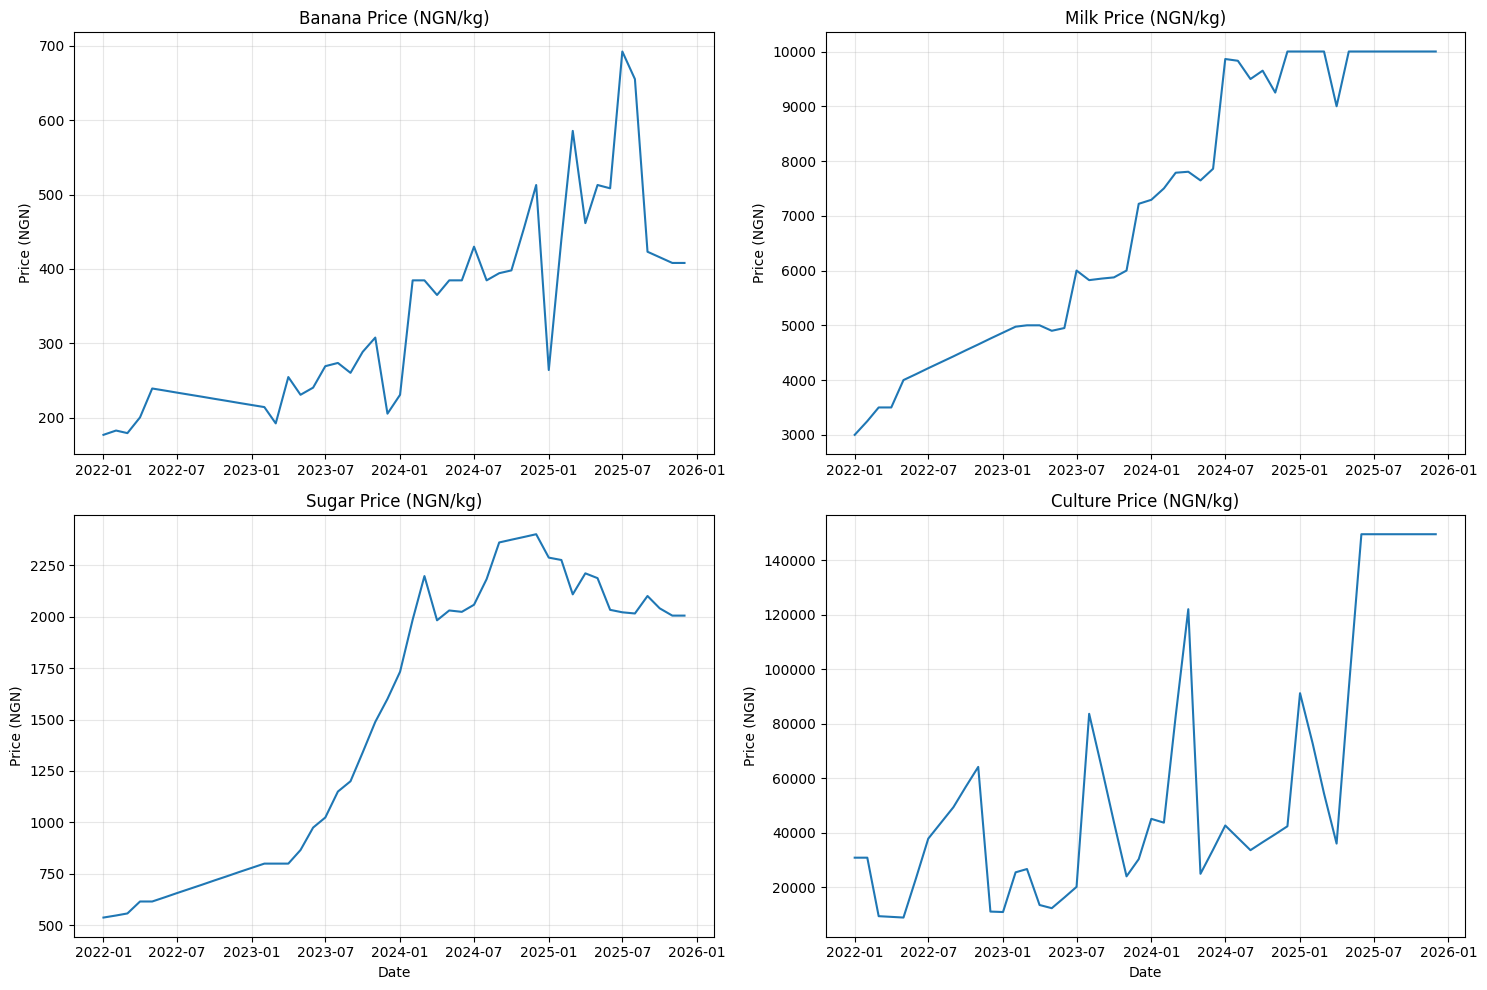

In [38]:
# Convert period to datetime for plotting
final_dataset['date'] = pd.to_datetime(final_dataset['period'], format='%Y%m')

# Plot price trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(final_dataset['date'], final_dataset['banana_price_ngn'])
axes[0, 0].set_title('Banana Price (NGN/kg)')
axes[0, 0].set_ylabel('Price (NGN)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(final_dataset['date'], final_dataset['milk_price_ngn'])
axes[0, 1].set_title('Milk Price (NGN/kg)')
axes[0, 1].set_ylabel('Price (NGN)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(final_dataset['date'], final_dataset['sugar_price_ngn'])
axes[1, 0].set_title('Sugar Price (NGN/kg)')
axes[1, 0].set_ylabel('Price (NGN)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(final_dataset['date'], final_dataset['culture_price_ngn'])
axes[1, 1].set_title('Culture Price (NGN/kg)')
axes[1, 1].set_ylabel('Price (NGN)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.2 Correlation Analysis

Examine relationships between commodity prices and external signals


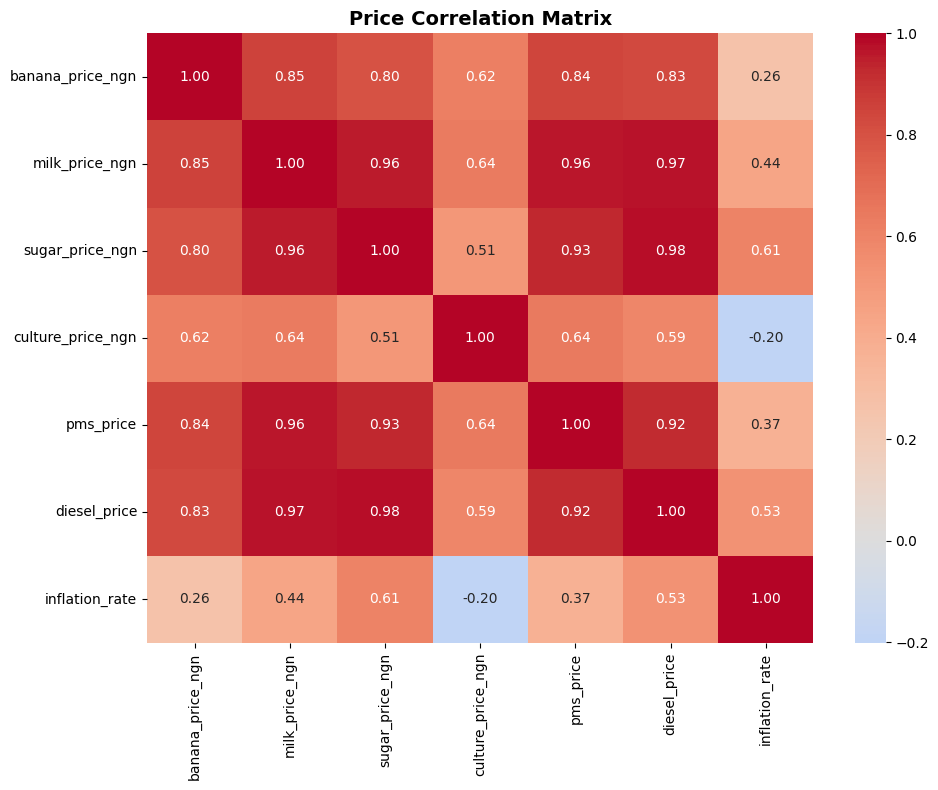

In [39]:
# Calculate correlations
corr_cols = ['banana_price_ngn', 'milk_price_ngn', 'sugar_price_ngn', 
              'culture_price_ngn', 'pms_price', 'diesel_price', 'inflation_rate']
correlation_matrix = final_dataset[corr_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Price Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Feature Engineering

**Goal**: Create time-series features for prediction 

**Features Created**:
- **Lagged Features**: Previous 1, 2, 3 month prices (only past data)
- **Moving Averages**: 3-month and 6-month rolling averages
- **External Signals**: Exchange rate, inflation, fuel prices
- **Temporal Features**: Month and year for seasonality




In [40]:
# Feature Engineering

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Prepare data for modeling
modeling_data = final_dataset.copy()
modeling_data['date'] = pd.to_datetime(modeling_data['period'], format='%Y%m')
modeling_data = modeling_data.sort_values('date').reset_index(drop=True)

# Target variables
target_vars = ['banana_price_ngn', 'milk_price_ngn', 'sugar_price_ngn', 'culture_price_ngn']

# Feature Engineering: Create lagged features (using past values only)
for var in target_vars:
    # Lag 1, 2, 3 months (past data only)
    modeling_data[f'{var}_lag1'] = modeling_data[var].shift(1)
    modeling_data[f'{var}_lag2'] = modeling_data[var].shift(2)
    modeling_data[f'{var}_lag3'] = modeling_data[var].shift(3)
    
    # Price changes (month-over-month, year-over-year)
    modeling_data[f'{var}_mom_change'] = modeling_data[var].pct_change(1)  # Month-over-month % change
    modeling_data[f'{var}_yoy_change'] = modeling_data[var].pct_change(12)  # Year-over-year % change

# Moving averages (using past data only)
for var in target_vars:
    modeling_data[f'{var}_ma3'] = modeling_data[var].shift(1).rolling(window=3, min_periods=1).mean()
    modeling_data[f'{var}_ma6'] = modeling_data[var].shift(1).rolling(window=6, min_periods=1).mean()
    modeling_data[f'{var}_ma12'] = modeling_data[var].shift(1).rolling(window=12, min_periods=1).mean()
    
    # Volatility (rolling standard deviation)
    modeling_data[f'{var}_volatility'] = modeling_data[var].shift(1).rolling(window=6, min_periods=1).std()

# External signal features
external_features = ['exchange_rate', 'inflation_rate', 'pms_price', 'diesel_price']

# Month and year features (for seasonality)
modeling_data['month'] = modeling_data['date'].dt.month
modeling_data['year'] = modeling_data['date'].dt.year

# Forward fill NaN values (to preserves rows given sparse data)
modeling_data = modeling_data.ffill().fillna(0).reset_index(drop=True)

print(f"Dataset shape: {modeling_data.shape}")
print(f"Date range: {modeling_data['date'].min()} to {modeling_data['date'].max()}")

Dataset shape: (48, 52)
Date range: 2022-01-01 00:00:00 to 2025-12-01 00:00:00


## 6. Train-Test Split (Chronological)

**Critical**: Time-series data must be split chronologically to prevent data leakage

- **Train**: All data before 2025-01-01
- **Test**: All data from 2025-01-01 onwards
- **No shuffling**: Preserves temporal order


In [41]:

split_date = '2025-01-01'  # Predict 2025 using data up to end of 2024
train_mask = modeling_data['date'] < split_date
test_mask = modeling_data['date'] >= split_date

train_data = modeling_data[train_mask].copy()
test_data = modeling_data[test_mask].copy()

print("Train-Test Split:")
print(f"Train period: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Train samples: {len(train_data)}")
print(f"\nTest period: {test_data['date'].min()} to {test_data['date'].max()}")
print(f"Test samples: {len(test_data)}")

# Prepare features and target
feature_cols = (
    [f'{var}_lag1' for var in target_vars] +
    [f'{var}_lag2' for var in target_vars] +
    [f'{var}_lag3' for var in target_vars] +
    [f'{var}_ma3' for var in target_vars] +
    [f'{var}_ma6' for var in target_vars] +
    external_features +
    ['month', 'year']
)

X_train = train_data[feature_cols]
X_test = test_data[feature_cols]
y_train = train_data[target_vars]
y_test = test_data[target_vars]

print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nFeatures: {feature_cols}")


Train-Test Split:
Train period: 2022-01-01 00:00:00 to 2024-12-01 00:00:00
Train samples: 36

Test period: 2025-01-01 00:00:00 to 2025-12-01 00:00:00
Test samples: 12

Features shape: (36, 26)
Target shape: (36, 4)

Features: ['banana_price_ngn_lag1', 'milk_price_ngn_lag1', 'sugar_price_ngn_lag1', 'culture_price_ngn_lag1', 'banana_price_ngn_lag2', 'milk_price_ngn_lag2', 'sugar_price_ngn_lag2', 'culture_price_ngn_lag2', 'banana_price_ngn_lag3', 'milk_price_ngn_lag3', 'sugar_price_ngn_lag3', 'culture_price_ngn_lag3', 'banana_price_ngn_ma3', 'milk_price_ngn_ma3', 'sugar_price_ngn_ma3', 'culture_price_ngn_ma3', 'banana_price_ngn_ma6', 'milk_price_ngn_ma6', 'sugar_price_ngn_ma6', 'culture_price_ngn_ma6', 'exchange_rate', 'inflation_rate', 'pms_price', 'diesel_price', 'month', 'year']


## 7. Modeling

**Approach**: Multiple time-series models for comparison

1. **Linear Regression** (Baseline) - Simple but interpretable
2. **Random Forest** - Handles non-linear relationships and feature interactions
3. **XGBoost** - Gradient boosting (future enhancement)
4. **LSTM** - Deep learning for sequences (future enhancement)

**Evaluation Metrics**:
- **MAE** (Mean Absolute Error) - Easy to interpret in NGN/kg
- **RMSE** (Root Mean Squared Error) - Penalizes large errors
- **MAPE** (Mean Absolute Percentage Error) - Percentage-based, scale-independent


In [42]:
# Model Training
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {}
predictions = {}
metrics = {}

# Train models for each target variable
for target in target_vars:
    print(f"\nTraining models for {target}...")
    
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train_target)
    lr_pred = lr.predict(X_test)
    
    #Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,           # More trees for better accuracy
        max_depth=15,                # Deeper trees to capture more patterns
        min_samples_split=5,         # Prevent overfitting
        min_samples_leaf=2,          # Prevent overfitting
        max_features='sqrt',         # Use sqrt of features for each split
        random_state=42,
        n_jobs=-1                    # Use all CPU cores
    )
    rf.fit(X_train, y_train_target)
    rf_pred = rf.predict(X_test)
    
    # Store models and predictions
    model_dict = {'LinearRegression': lr, 'RandomForest': rf}
    pred_dict = {
        'LinearRegression': lr_pred,
        'RandomForest': rf_pred,
        'Actual': y_test_target.values
    }
    
    # XGBoost
    if XGBOOST_AVAILABLE:
        xgb = XGBRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_train, y_train_target)
        xgb_pred = xgb.predict(X_test)
        model_dict['XGBoost'] = xgb
        pred_dict['XGBoost'] = xgb_pred
    
    models[target] = model_dict
    predictions[target] = pred_dict
    
    # Calculate metrics
    lr_mae = mean_absolute_error(y_test_target, lr_pred)
    lr_rmse = np.sqrt(mean_squared_error(y_test_target, lr_pred))
    lr_mape = np.mean(np.abs((y_test_target - lr_pred) / y_test_target)) * 100
    
    rf_mae = mean_absolute_error(y_test_target, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test_target, rf_pred))
    rf_mape = np.mean(np.abs((y_test_target - rf_pred) / y_test_target)) * 100
    
    metric_dict = {
        'LinearRegression': {'MAE': lr_mae, 'RMSE': lr_rmse, 'MAPE': lr_mape},
        'RandomForest': {'MAE': rf_mae, 'RMSE': rf_rmse, 'MAPE': rf_mape}
    }
    
    xgb_mae = mean_absolute_error(y_test_target, xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_test_target, xgb_pred))
    xgb_mape = np.mean(np.abs((y_test_target - xgb_pred) / y_test_target)) * 100
    metric_dict['XGBoost'] = {'MAE': xgb_mae, 'RMSE': xgb_rmse, 'MAPE': xgb_mape}
    
    metrics[target] = metric_dict
    
    print(f"  Linear Regression - MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, MAPE: {lr_mape:.2f}%")
    print(f"  Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, MAPE: {rf_mape:.2f}%")
    print(f"  XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2f}%")



Training models for banana_price_ngn...
  Linear Regression - MAE: 258.78, RMSE: 293.04, MAPE: 55.01%
  Random Forest - MAE: 97.38, RMSE: 135.29, MAPE: 19.51%
  XGBoost - MAE: 98.47, RMSE: 131.13, MAPE: 21.29%

Training models for milk_price_ngn...
  Linear Regression - MAE: 6440.13, RMSE: 7099.18, MAPE: 64.76%
  Random Forest - MAE: 763.92, RMSE: 791.31, MAPE: 7.66%
  XGBoost - MAE: 479.32, RMSE: 506.23, MAPE: 4.84%

Training models for sugar_price_ngn...
  Linear Regression - MAE: 792.72, RMSE: 939.55, MAPE: 38.66%
  Random Forest - MAE: 86.17, RMSE: 98.64, MAPE: 4.19%
  XGBoost - MAE: 126.84, RMSE: 146.11, MAPE: 6.14%

Training models for culture_price_ngn...
  Linear Regression - MAE: 1097979.22, RMSE: 1260784.98, MAPE: 922.45%
  Random Forest - MAE: 72925.95, RMSE: 83496.14, MAPE: 55.77%
  XGBoost - MAE: 73318.49, RMSE: 85544.13, MAPE: 54.11%


## 7.1 Naive Baseline Comparison
- Check if models predictions beat naive baseline(using last months price = month to be predicteds price)


In [50]:
naive_metrics = {}
results_summary = []

print("MODEL KOMBAT")

for target in target_vars:
    y_actual = y_test[target].values
    commodity = target.replace('_price_ngn', '').title()
    
    # use last months price as prediction
    naive_pred = X_test[f'{target}_lag1'].values
    
    # how wrong is naive on average
    naive_error = np.mean(np.abs((y_actual - naive_pred) / y_actual)) * 100
    naive_metrics[target] = {'MAPE': naive_error}

    # how wrong is model on average
    best_model = min(metrics[target].keys(), key=lambda m: metrics[target][m]['MAPE'])
    model_error = metrics[target][best_model]['MAPE']
    
    if model_error < naive_error:
        verdict = "ml wins"
    else:
        verdict = "naive wins"
    
    results_summary.append({
        'commodity': commodity,
        'model_error': model_error,
        'naive_error': naive_error,
        'verdict': verdict
    })
    
    print(f"{commodity}")
    print(f"  ml model off by {model_error:.1f}% on average")
    print(f"  naive off by {naive_error:.1f}% on average")
    print(f"  {verdict}")
    print()

print()
print("summary")
print()
print(f"{'ingredient':<12} {'ml error':<12} {'naive error':<14} {'use':<10}")
print()
for r in results_summary:
    use = "ml" if r['verdict'] == "ml wins" else "naive"
    print(f"{r['commodity']:<12} {r['model_error']:.1f}%{'':<8} {r['naive_error']:.1f}%{'':<10} {use:<10}")



MODEL KOMBAT
Banana
  ml model off by 19.5% on average
  naive off by 24.0% on average
  ml wins

Milk
  ml model off by 4.8% on average
  naive off by 1.8% on average
  naive wins

Sugar
  ml model off by 4.2% on average
  naive off by 3.0% on average
  naive wins

Culture
  ml model off by 54.1% on average
  naive off by 21.9% on average
  naive wins


summary

ingredient   ml error     naive error    use       

Banana       19.5%         24.0%           ml        
Milk         4.8%         1.8%           naive     
Sugar        4.2%         3.0%           naive     
Culture      54.1%         21.9%           naive     


## 7.2 Time-Series Cross-Validation

**Problem**: A single train-test split with only 48 data points isn't robust.

**Solution**: Use expanding window cross-validation:
- Start with minimum training data (e.g., 24 months)
- Predict next month
- Add that month to training, predict the next
- Repeat until end of data

This gives us multiple test points and more reliable metrics.

- see if it helps model predict better when compared again to baseline


In [52]:
# cross validation - testing the model multiple times to make sure results are consistent
# instead of one test, we do 5 tests on different time periods

from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

cv_results = {target: {'RandomForest': [], 'Naive': []} for target in target_vars}

X_full = modeling_data[feature_cols].iloc[6:]
y_full = modeling_data[target_vars].iloc[6:]

print(f"total data points: {len(X_full)}")
print()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_full)):
    X_train_cv = X_full.iloc[train_idx]
    X_test_cv = X_full.iloc[test_idx]
    y_train_cv = y_full.iloc[train_idx]
    y_test_cv = y_full.iloc[test_idx]
    
    for target in target_vars:
        rf_cv = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        rf_cv.fit(X_train_cv, y_train_cv[target])
        rf_pred_cv = rf_cv.predict(X_test_cv)
        
        rf_error = np.mean(np.abs((y_test_cv[target].values - rf_pred_cv) / y_test_cv[target].values)) * 100
        cv_results[target]['RandomForest'].append(rf_error)
        
        naive_pred_cv = X_test_cv[f'{target}_lag1'].values
        naive_error = np.mean(np.abs((y_test_cv[target].values - naive_pred_cv) / y_test_cv[target].values)) * 100
        cv_results[target]['Naive'].append(naive_error)

print("MODEL KOMBAT 2 - Winner takes all")
print()

for target in target_vars:
    commodity = target.replace('_price_ngn', '').title()
    
    rf_avg = np.mean(cv_results[target]['RandomForest'])
    naive_avg = np.mean(cv_results[target]['Naive'])
    
    if rf_avg < naive_avg:
        verdict = "ml wins"
    else:
        verdict = "naive wins"
    
    print(f"{commodity}")
    print(f"  ml model off by {rf_avg:.1f}% on average across tests")
    print(f"  naive off by {naive_avg:.1f}% on average across tests")
    print(f"  {verdict}")
    print()

print()
print("naive baseline wins  FATALITY - FLAWLESS VICTORY")


total data points: 42

MODEL KOMBAT 2 - Winner takes all

Banana
  ml model off by 16.2% on average across tests
  naive off by 15.2% on average across tests
  naive wins

Milk
  ml model off by 9.6% on average across tests
  naive off by 3.3% on average across tests
  naive wins

Sugar
  ml model off by 14.5% on average across tests
  naive off by 4.7% on average across tests
  naive wins

Culture
  ml model off by 43.1% on average across tests
  naive off by 38.1% on average across tests
  naive wins


naive baseline wins  FATALITY - FLAWLESS VICTORY


## 8. Model Evaluation
- We already know our model is useless, but lets see visualize how useless it really is.
- **Visualization**: Predictions vs. Actual prices for test period


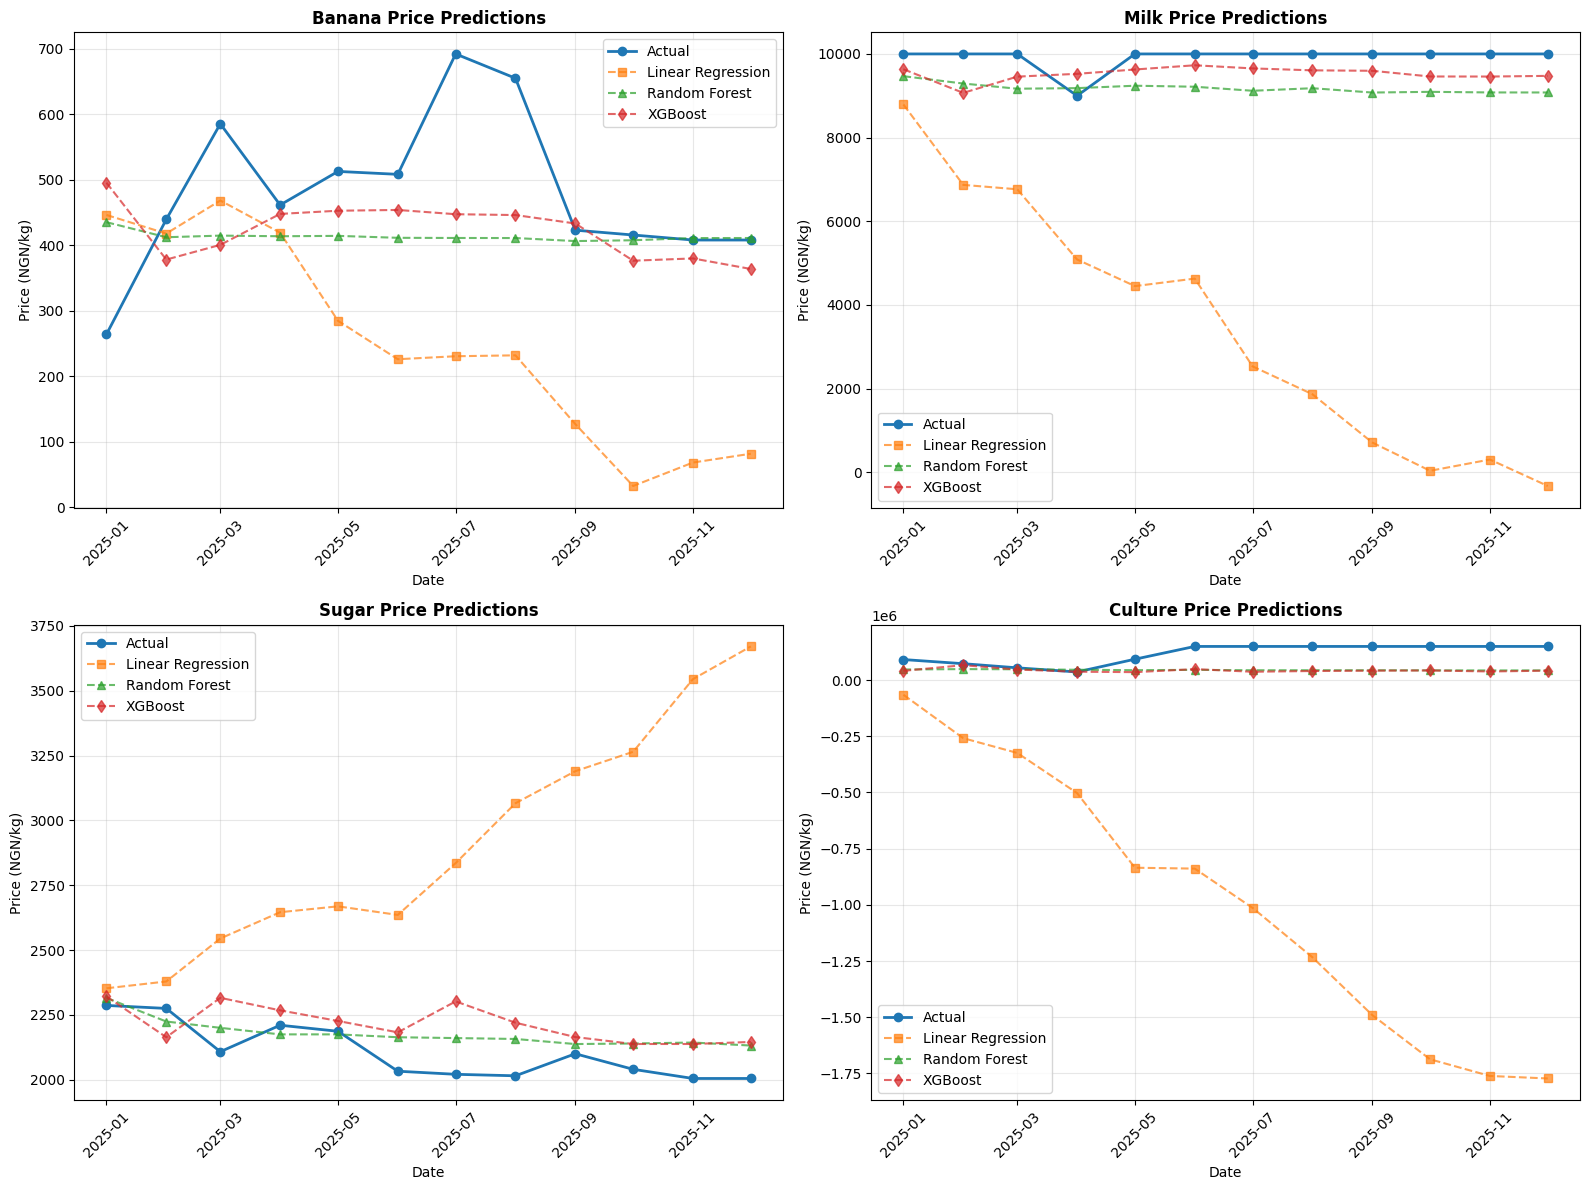

In [53]:
# Visualize predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, target in enumerate(target_vars):    
    ax = axes[idx]    
    dates = test_data['date'].values        
    ax.plot(dates, predictions[target]['Actual'], 'o-', label='Actual', linewidth=2, markersize=6)    
    ax.plot(dates, predictions[target]['LinearRegression'], 's--', label='Linear Regression', alpha=0.7)    
    ax.plot(dates, predictions[target]['RandomForest'], '^--', label='Random Forest', alpha=0.7)    
    if 'XGBoost' in predictions[target]:        
        ax.plot(dates, predictions[target]['XGBoost'], 'd--', label='XGBoost', alpha=0.7)        
    ax.set_title(f'{target.replace("_price_ngn", "").title()} Price Predictions', fontsize=12, fontweight='bold')    
    ax.set_xlabel('Date')    
    ax.set_ylabel('Price (NGN/kg)')    
    ax.legend()    
    ax.grid(True, alpha=0.3)    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## 9. Summary & Key Findings


### Goal
Predict monthly commodity prices to support analysis and planning.

### Data & Pipeline
Built a pipeline that collects, cleans, and combines multiple sources (commodity prices, forex, fuel, inflation) into a dataset with 48 monthly observations. Applied feature engineering including lags, moving averages, and volatility. Missing data was carefully handled and interpolated where necessary.

### Modeling
Tested Linear Regression, Random Forest, and XGBoost models, benchmarked against a simple baseline (last month’s price). Cross-validation was used to ensure reliable evaluation.

### Key Findings

- For Milk and Sugar, which showed low month-to-month variability in this dataset, simple baseline predictions performed as well as or better than the ML models tested.

- For Banana, ML and baseline predictions were roughly comparable.

- Sparse or irregular data (Culture imports) limited predictive performance for all approaches.

### Takeaways

- In datasets with limited observations or low variability, simple baseline methods can perform as well as ML models.

- ML may show greater value if richer datasets, higher-frequency observations, or additional external signals are available.

- The project demonstrates a reliable workflow for collecting, cleaning, and integrating multiple data sources, creating a foundation for future predictive modeling.


